In [0]:
import cv2 
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


# DATA PROCESSING 

In [0]:
nombre_clases_train="/content/drive/My Drive/Vision/AsuMayo/AsuMayoTrain/"
nombre_clases_test="/content/drive/My Drive/Vision/AsuMayo/AsuMayoTest/"
video_names_train = os.listdir("/content/drive/My Drive/Vision/AsuMayo/AsuMayoTrain/")
video_names_test = os.listdir("/content/drive/My Drive/Vision/AsuMayo/AsuMayoTest/")

resize_value=224
X_train,y_train,X_test,y_test=[],[],[],[]

for i in range(len(video_names_train)):
    print(video_names_train[i])
    capture = cv2.VideoCapture(nombre_clases_train+video_names_train[i])
    accion=video_names_train[i]    
    read_flag, frame = capture.read()
    while (read_flag):
      X_train.append(cv2.resize(frame,(resize_value,resize_value))*1)
      etiqueta= 0 if(accion[8:10] == "np") else 1
      y_train.append(int(etiqueta))
      read_flag, frame = capture.read()
      
X_train = np.r_[X_train]        
y_train = np.r_[y_train]

for i in range(len(video_names_test)):
    print(video_names_test[i])
    capture = cv2.VideoCapture(nombre_clases_test+video_names_test[i])
    accion=video_names_test[i]    
    read_flag, frame = capture.read()
    while (read_flag):
      X_test.append(cv2.resize(frame,(resize_value,resize_value))*1)
      etiqueta= 0 if(accion[-6:-4] == "np") else 1
      y_test.append(int(etiqueta))
      read_flag, frame = capture.read()
    
X_test = np.r_[X_test]        
y_test = np.r_[y_test]

# Opponet Color and ORB

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3dfdb9a7f0>,
 <matplotlib.image.AxesImage at 0x7f3dfdacc7f0>)

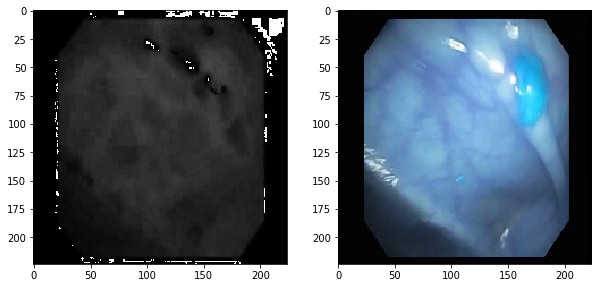

In [0]:
orig =X_train[900]  
B,G,R=orig[:,:,0],orig[:,:,1],orig[:,:,2]
O1= np.double((R-G)/np.sqrt(2))
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(O1,cmap='gray')
plt.subplot(122),plt.imshow(orig)

In [0]:
import gc
path_classes_train="./AsuMayo/AsuMayoTrain/"

descriptor_extractor = ORB(n_keypoints=30)
arrayORB,Y_train,ignoradas=[],[],0

for i in range(len(X_train)):
    orig =X_train[i]  
    B,G,R=orig[:,:,0],orig[:,:,1],orig[:,:,2]
    O1= np.double((R-G)/np.sqrt(2))  #O1-O2
    descriptor_extractor.detect_and_extract(O1)
    keypoints1 = descriptor_extractor.keypoints
    if(len(keypoints1)>=30):
      descriptorImage = descriptor_extractor.descriptors
      arrayORB.append(descriptorImage)
      Y_train.append(y_train[i])  
    else: 
      ignoradas+=1
    gc.collect()
    
gc.collect() # explicitelly clean memory
arrayORB1=np.array(arrayORB)
array_ORB=np.concatenate(arrayORB1)
print("Imágenes ignoradas debido a pocos keypoints: ", ignoradas)

Imágenes ignoradas debido a pocos keypoints:  30


In [0]:
print ("Comprobando tamaño: ",array_ORB.shape,30*(len(X_train)-ignoradas))

Comprobando tamaño:  (566160, 256) 566160


# **BUILD HISTOGRAM AND KMEANS** 

In [0]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [0]:
from sklearn.cluster import KMeans

v_words =70

kmeans = KMeans(n_clusters=v_words) 
kmeans.fit(array_ORB)
visual_dictionary=kmeans.cluster_centers_
print (visual_dictionary.shape)

(70, 256)


# EXTRACT TRAINING AND TEST DATA

In [0]:
import gc

arr_h_test,arr_h_train=[],[]

#array_ORB es de train
#path_classes = '/content/drive/My Drive/image_set/'
path_classes = '/content/drive/My Drive/data/'
descriptor_extractor = ORB(n_keypoints=30)

for i in range(len(arrayORB)): 
    histo = build_histogram(arrayORB[i], kmeans)
    arr_h_train.append(histo)

#array ORB de test
descriptor_extractorTest = ORB(n_keypoints=30)
arrayORB_t,Y_test=[],[]
    
for i in range(len(X_test)):
    orig = X_test[i]    
    B,G,R=orig[:,:,0],orig[:,:,1],orig[:,:,2]
    O1= np.double((R-G)/np.sqrt(2))  #O1-O2
    descriptor_extractor.detect_and_extract(rgb2gray(O1))
    keypoints1 = descriptor_extractor.keypoints
    if(len(keypoints1)>=30):
      descriptorImage = descriptor_extractor.descriptors
      arrayORB_t.append(descriptorImage)
      Y_test.append(y_test[i])

for i in range(len(arrayORB_t)): 
    histo1 = build_histogram(arrayORB_t[i], kmeans)
    arr_h_test.append(histo1)

arr_h_train=np.array(arr_h_train)
arr_h_test=np.array(arr_h_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

print (arr_h_test.shape, arr_h_train.shape, Y_train.shape, Y_test.shape)

(17573, 70) (18872, 70) (18872,) (17573,)


# **CLASSIFIERS**

In [0]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

**KNN**


10 0.8304785750867809
20 0.8320719285267171
30 0.8311045353667558
40 0.83025095316679
50 0.8291697490468332
60 0.8283730723268651
70 0.8277471120468901
80 0.8277471120468901
90 0.8277471120468901
100 0.8270642462869174


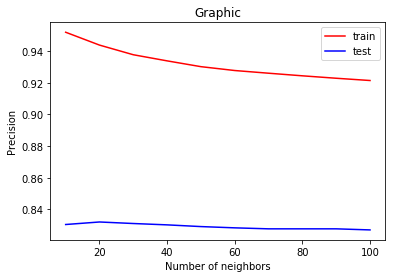

In [0]:
accuracy_KNN,accuracy_KNN_train=[],[]
x=[i for i in range(10,110,10)]
for i in range(10,110,10):
  KN_est = KNeighborsClassifier(n_neighbors=i)
  KN_est.fit(arr_h_train, Y_train)
  KN_pr = KN_est.predict(arr_h_test)
  accuracy_KNN_train.append(KN_est.score(arr_h_train, Y_train))
  accuracy_KNN.append(KN_est.score(arr_h_test, Y_test))
  print (i,KN_est.score(arr_h_test, Y_test))

#results
plt.plot(x, accuracy_KNN_train, color='r', label='train')
plt.plot(x, accuracy_KNN, color='b', label='test')
plt.title('Graphic')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Number of neighbors')
plt.show()

0.8320719285267171


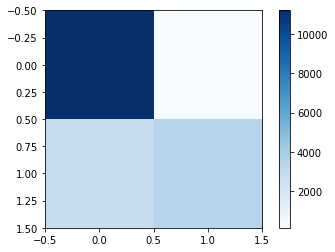

In [0]:
KN_est = KNeighborsClassifier(n_neighbors=20)
KN_est.fit(arr_h_train, Y_train)
KN_pr = KN_est.predict(arr_h_test)
print (KN_est.score(arr_h_test, Y_test))
cm_test = confusion_matrix(Y_test, KN_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

**NAIVE GAUSSIAN**

0.8522164684459114


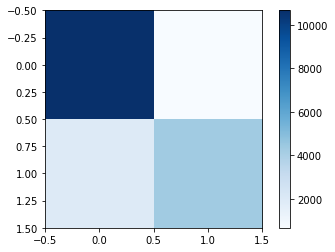

In [0]:
# With Naive Gaussian Classifier
accuracy_GN=[]
GN_est = GaussianNB()
GN_est.fit(arr_h_train, Y_train)
GN_pr = GN_est.predict(arr_h_test)
print (GN_est.score(arr_h_test, Y_test))
cm_test = confusion_matrix(Y_test, GN_pr)
accuracy_GN.append(GN_est.score(arr_h_test, Y_test))
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

**RANDOM FOREST**

10 0.8423718204063051
20 0.8495988163660161
30 0.8527855232458886
40 0.8507938314459682
50 0.8524440903659022
60 0.8521026574859158
70 0.8521026574859158
80 0.8527286177658908
90 0.8511921698059524
100 0.8523302794059068


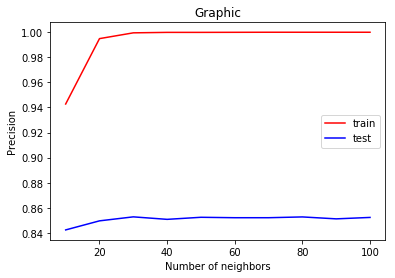

In [0]:
# With Random ForesT
x=[i for i in range(10,110,10)]
accuracy_RF,accuracy_RF_train=[],[]
for i in range(10,110,10):
  RF_est = RandomForestClassifier(n_estimators=i,criterion='entropy', max_depth=i)
  RF_est.fit(arr_h_train, Y_train)
  RF_pr = RF_est.predict(arr_h_test)
  accuracy_RF.append(RF_est.score(arr_h_test, Y_test))
  accuracy_RF_train.append(RF_est.score(arr_h_train, Y_train))
  print(i, RF_est.score(arr_h_test, Y_test))
  
#results
plt.plot(x, accuracy_RF_train, color='r', label='train')
plt.plot(x, accuracy_RF, color='b', label='test')
plt.title('Graphic')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('')
plt.show()

0.8378762874864849
[[11199   138]
 [ 2711  3525]]


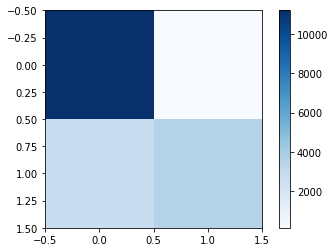

In [0]:
# With Random Forest
RF_est = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=10)
RF_est.fit(arr_h_train, Y_train)
RF_pr = RF_est.predict(arr_h_test)
print( RF_est.score(arr_h_test, Y_test))
cm_test = confusion_matrix(Y_test, RF_pr)
print(cm_test)
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

**SVM**

rbf 0.8579070164456837
linear 0.8575086780856996
poly 0.8546064986058157
sigmoid 0.8216013202071359


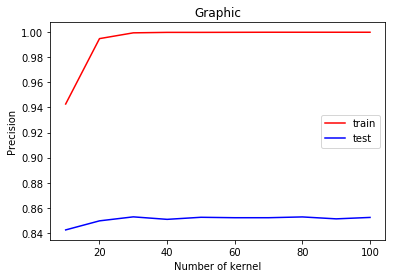

In [0]:
[i for i in range(4)]
# With Support vector Machine
accuracy_SVM,accuracy_SVM_train=[],[]
kernel=['rbf','linear','poly','sigmoid']
for i in kernel:
  SV_est = SVC(kernel=i,gamma='scale')
  SV_est.fit(arr_h_train, Y_train)
  SV_pr = SV_est.predict(arr_h_test)
  accuracy_SVM_train.append(SV_est.score(arr_h_train, Y_train))
  accuracy_SVM.append(SV_est.score(arr_h_test, Y_test))
  print (i,SV_est.score(arr_h_test, Y_test))

#results
plt.plot(x, accuracy_RF_train, color='r', label='train')
plt.plot(x, accuracy_RF, color='b', label='test')
plt.title('Graphic')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Number of kernel')
plt.show()

0.8579070164456837
[[11124   213]
 [ 2284  3952]]


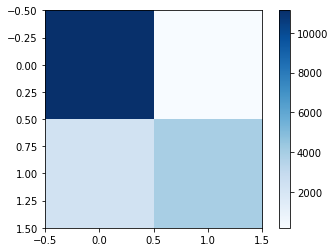

In [0]:
# With Support vector Machine
SV_est = SVC(kernel='rbf',gamma='scale')
SV_est.fit(arr_h_train, Y_train)
SV_pr = SV_est.predict(arr_h_test)
print (SV_est.score(arr_h_test, Y_test))
cm_test = confusion_matrix(Y_test, SV_pr)
print(cm_test)
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

**The best classifier**

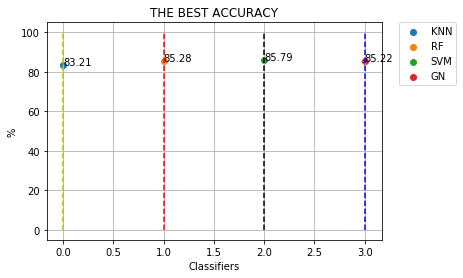

In [0]:
classi=['KNN','RF','SVM', 'GB']
acc=[np.round(np.max(accuracy_KNN)*100,2),np.round(np.max(accuracy_RF)*100,2),np.round(np.max(accuracy_SVM)*100,2), 
    np.round(np.max(accuracy_GN)*100,2)]
x=[i for i in range(len(classi))]
for i, txt in enumerate(acc):
    plt.annotate(txt, (x[i], acc[i]))
    
plt.scatter(0, np.max(accuracy_KNN)*100)
plt.scatter(1,  np.max(accuracy_RF)*100)
plt.scatter(2,  np.max(accuracy_SVM)*100)
plt.scatter(3,  np.max(accuracy_GN)*100)
plt.title("THE BEST ACCURACY"), plt.ylabel("%"),plt.xlabel("Classifiers")
plt.vlines(0, 0, 100,colors="y", linestyles="dashed")
plt.vlines(1, 0, 100,colors="r", linestyles="dashed")
plt.vlines(2, 0, 100,colors="black", linestyles="dashed")
plt.vlines(3, 0, 100,colors="blue", linestyles="dashed")
plt.grid()
plt.legend(("KNN","RF","SVM","GN"),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()